In [14]:
import geopandas as gpd
from osgeo import ogr 
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from osgeo import gdal
import shapefile
from osgeo import osr
import pandas as pd
import rasterstats as rs
import re
import glob

In [2]:
%%time
pointsfile="AUS_points_5km.shp"
sjer_plots_points = gpd.read_file(pointsfile)
# Create a buffered polygon layer from your plot location points
sjer_plots_poly = sjer_plots_points.copy()
# Buffer each point using a 700 meter circle radius
# and replace the point geometry with the new buffered geometry
sjer_plots_poly["geometry"] = sjer_plots_points.geometry.buffer(700)
sjer_plots_poly.head()

Wall time: 31.7 s


,VALUE,geometry
0,1.0,"POLYGON ((1152200.000 -1012500.000, 1152196.62..."
1,1.0,"POLYGON ((1157200.000 -1012500.000, 1157196.62..."
2,1.0,"POLYGON ((1157200.000 -1017500.000, 1157196.62..."
3,1.0,"POLYGON ((1162200.000 -1017500.000, 1162196.62..."
4,1.0,"POLYGON ((1202200.000 -1032500.000, 1202196.62..."


<AxesSubplot:>

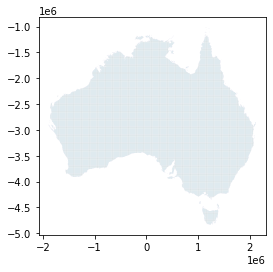

In [3]:
sjer_plots_poly.plot()

In [4]:
folder="ABS1x1km_Aus_Pop_Grid_2006_2020/data_provided/"
tiffile="apg06e_f_001_20210512.tif"

In [5]:
%%time
##RASTERIO
src = rasterio.open(folder+tiffile)
array_rasterio = src.read(1)
nodataval= src.nodatavals

if np.any(array_rasterio == nodataval):
    array_rasterio[array_rasterio == nodataval] = np.nan
    
print(np.shape(array_rasterio))

(4100, 7401)
Wall time: 431 ms


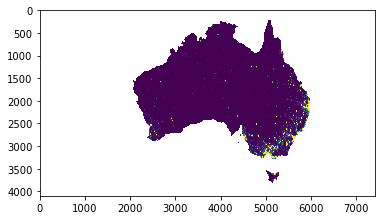

In [6]:
plt.imshow(array_rasterio,vmin=0,vmax=10)
plt.show()

In [7]:
%%time
##GDAL
gdal_data = gdal.Open(folder+tiffile)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()
array_gdal = gdal_data.ReadAsArray().astype(np.float)
gt = gdal_data.GetGeoTransform()

if np.any(array_gdal == nodataval):
    array_gdal[array_gdal == nodataval] = np.nan
    
print(np.shape(array_gdal))

(4100, 7401)
Wall time: 517 ms


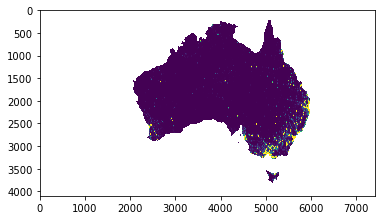

In [9]:
plt.imshow(array_gdal,vmin=0,vmax=10)
plt.show()

In [10]:
%%time
def returnValuePoints(x, y):
    point = (x, y)
    col = int((point[0] - -3901000.0) /1000.0)
    row = int((point[1] - -1000000.0) / -1000.0)
    return (row, col)

sjer_plots_points["ind"] = sjer_plots_points.apply(lambda x: returnValuePoints(x.geometry.x, x.geometry.y), axis=1)

Wall time: 50 s


In [11]:
def coregPoint(point,data,region):
    '''
    Finds the nearest neighbour to a point from a bunch of other points
    point - array([longitude,latitude])
    data - array
    region - integer, same units as data
    '''
    tree = scipy.spatial.cKDTree(data)
    dists, indexes = tree.query(point,k=1,distance_upper_bound=region) 

    if indexes==len(data):
        return 'inf'
    else:
        return (indexes,dists)
    

    
def points_in_circle(circle, arr):
    '''
    A generator to return all points whose indices are within given circle.
    http://stackoverflow.com/a/2774284
    Warning: If a point is near the the edges of the raster it will not loop 
    around to the other side of the raster!
    '''
    i0,j0,r = circle
    

    for i in range(intceil(i0-r),intceil(i0+r)):
        ri = np.sqrt(r**2-(i-i0)**2)
        for j in range(intceil(j0-ri),intceil(j0+ri)):
            if (i >= 0 and i < len(arr[:,0])) and (j>=0 and j < len(arr[0,:])):               
                yield arr[i][j]

#            
def intceil(x):
    return int(np.ceil(x))                                            

#
def coregRaster(j0,i0,data,region):
    '''
    Finds the mean value of a raster, around a point with a specified radius.
    point - array([longitude,latitude])
    data - array
    region - integer, same units as data
    '''
    #i0=point[1]
    #j0=point[0]
    r=region #In units of degrees
    pts_iterator = points_in_circle((i0,j0,region), data)
    #print(data)
    #print(pts_iterator)
    pts = np.array(list(pts_iterator))
    #remove values outside the region which for these data are set to -9999.
    #pts = pts[pts != -9999.]
    #if np.isnan(np.nanmean(pts)):
        #print(point,"nan")
    #    pts=np.median(data)
    #    print("returning",pts)
    
    squares= np.count_nonzero(~np.isnan(pts))

    #return(scipy.stats.nanmean(pts)) #deprecated from scipy 0.15
    return(np.nansum(pts),squares)

def get_coords_at_point(gt, lon, lat):
    row = int((lon - gt[0])/gt[1])
    col = int((lat - gt[3])/gt[5])
    return col, row

In [12]:
%%time
pop_area = sjer_plots_points.apply(lambda x: coregRaster(x.ind[0], x.ind[1],array_gdal,7), axis=1)

Wall time: 2min 3s


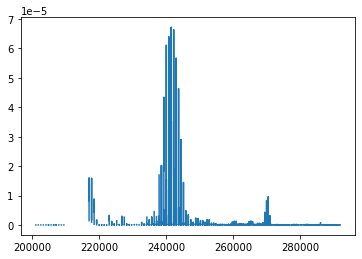

In [15]:
sjer_plots_points[['pop', 'area']] = pd.DataFrame(pop_area.tolist(), index=pop_area.index)
sjer_plots_points["pop_density"]=sjer_plots_points["pop"]/(sjer_plots_points["area"]*5000**2)
plt.plot(sjer_plots_points["pop_density"])

In [92]:
print(gt)

(-3901000.0, 1000.0, 0.0, -1000000.0, 0.0, -1000.0)


In [60]:
x=sjer_plots_points.geometry.x[500]
y=sjer_plots_points.geometry.y[500]


In [83]:
proj = osr.SpatialReference(wkt=gdal_data.GetProjection())

In [79]:
gt

(-3901000.0, 1000.0, 0.0, -1000000.0, 0.0, -1000.0)

In [74]:
%%time
#val = df.apply(lambda x: coregRaster(sjer_plots_points.geometry.x, sjer_plots_points.geometry.y,700,array), axis=1)

radius = 7

col,row = get_coords_at_point(gt, x,y)
buff_arr = coregRaster(row, col,array_gdal,radius)

Wall time: 0 ns


In [90]:
print(np.count_nonzero(~np.isnan(array_gdal)))

print(area)

7690678
50.0


TypeError: Invalid shape (787131,) for image data

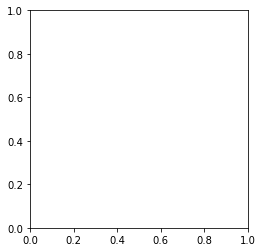

In [50]:
plt.imshow(buffer_points)

In [86]:
prj = gdal_data.GetProjection()
print(prj)

PROJCS["GDA_1994_Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [99]:
coords=shapes[0].points[0]

def get_coords_at_point(rasterfile, pos):
    gdata = gdal.Open(rasterfile)
    gt = gdata.GetGeoTransform()
    data = gdata.ReadAsArray().astype(np.float)
    row = int((pos[1] - gt[0])/gt[1])
    col = int((pos[0] - gt[3])/gt[5])
    return col, row

radius = 700 # in units of pixels

row, col = get_coords_at_point(tiffile, pos = coords) 
circle = (row, col, radius)

In [100]:
circle

(-2151, 2888, 700)

In [101]:
def points_in_circle(circle, arr):
    buffer_points = []
    i0, j0, r = circle
    
    def int_ceiling(x):
        return int(np.ceil(x))
    
    for i in range(int_ceiling(i0 - r), int_ceiling(i0 + r)):
        ri = np.sqrt(r**2 - (i - i0)**2)
        
        for j in range(int_ceiling(j0 - ri), int_ceiling(j0 + ri)):
            buffer_points.append(arr[i][j])
            arr[i][j] = np.nan
    
    return buffer_points

buffer_points = points_in_circle(circle, data_array)

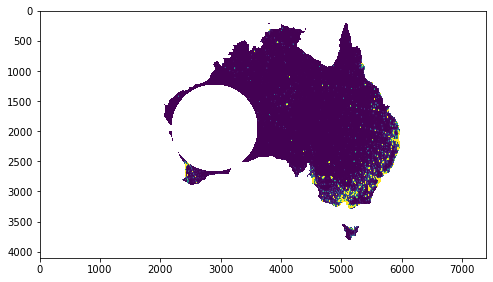

In [113]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
#plt.axis("off")
plt.imshow(data_array, cmap = "viridis",vmin=0,vmax=10)
#plt.plot(coords[0],coords[1],'kx')
plt.show()

In [114]:
mean = np.nanmean(buffer_points)
std = np.nanstd(buffer_points)
variance = np.nanvar(buffer_points)
summ = np.nansum(buffer_points)

In [117]:
variance

32.05252805112663

In [25]:
%%time


## Read in population rasters
poprasts = glob.glob('ABS1x1km_Aus_Pop_Grid_2006_2020/' +
                     'data_provided/apg07e_f_001_20210512.tif')

grid = gpd.read_file('AUS_points_5km.shp')

## Add an FID in there - if one doesn't already exist
grid.insert(0, 'FID', range(1, len(grid) + 1))


## To see how long it takes

Wall time: 27.8 s


In [26]:
## Define a 'sumna' function that removes missing, and any negative values
def sumna(x):
    return np.nansum(x[x>0])

## Function for one year's extract
def popbuff(buff):
    b = grid.geometry.buffer(buff)
    pop = rs.zonal_stats(b,
                         poprast.read(1),
                         nodata = 0,
                         affine = poprast.transform,
                         stats = 'sum',
                         add_stats = {'sumna' : sumna})
    out = gpd.GeoDataFrame(pop)['sumna']
    out = out/(b.area/1e6)
    return out

buffs = [700] #, 1000, 1500, 2000, 3000, 5000, 10000]

In [32]:
with rasterio.open(poprasts[0]) as poprast:
        yr = str(20) + re.sub(".*(apg|APG)(\\d{2}).*", "\\2", poprasts[0])
        print(yr)
        popdf = list(map(popbuff, buffs))

2007


KeyboardInterrupt: 

In [36]:
with rasterio.open(poprasts[0]) as poprast:
    print(poprast)
    print(poprast.read(1))

<open DatasetReader name='ABS1x1km_Aus_Pop_Grid_2006_2020/data_provided/apg07e_f_001_20210512.tif' mode='r'>
[[-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]
 [-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]
 [-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]
 ...
 [-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]
 [-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]
 [-3.402823e+38 -3.402823e+38 -3.402823e+38 ... -3.402823e+38
  -3.402823e+38 -3.402823e+38]]
